In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [267]:
def burr_rnd(alpha=1, lambda_type=1, tau=2, n=1, m=1):
    u = np.zeros((n, m))
    for i in range(m):
        u[:, i] = (lambda_type * (np.random.uniform(0, 1, n) ** (-1 / alpha) - 1)) ** (1 / tau)
    return u


In [268]:
def mixexp_rnd(p=0.5, beta1=1, beta2=2, n=1, m=1):
    y = np.random.exponential(beta2, n * m)
    aux = np.random.uniform(0, 1, n * m) <= p
    
    if np.any(aux):
        y[aux] = np.random.exponential(beta1, np.sum(aux))

    return y.reshape(n, m)

In [269]:
def sim_hpp(lambda_type, T, N):
    if lambda_type <= 0 or not np.isscalar(lambda_type):
        raise ValueError("simHPP: Lambda must be a positive scalar.")
    if T <= 0 or not np.isscalar(T):
        raise ValueError("simHPP: T must be a positive scalar.")
    if N <= 0 or not np.isscalar(N):
        raise ValueError("simHPP: N must be a positive scalar.")

    EN = np.random.poisson(lambda_type * T, N)
    max_EN = 2 * np.max(EN) + 2
    y = np.full((max_EN, N, 2), T)
    y[:, :, 1] = np.tile(EN, (max_EN, 1))
    
    for i in range(N):
        if EN[i] > 0:
            ttmp = np.sort(T * np.random.uniform(size=EN[i]))
            y[:2 * EN[i] + 1, i, 0] = np.concatenate(([0], np.repeat(ttmp, 2)))
            y[:2 * EN[i] + 1, i, 1] = np.concatenate(([0], np.floor(np.arange(1, 2 * EN[i]) / 2), [EN[i]]))

    return y

In [270]:
def pareto_rnd(alpha=1, lambda_type=1, n=1, m=1):
    u = np.zeros((n, m))
    for i in range(m):
        u[:, i] = lambda_type * (np.random.uniform(0, 1, n) ** (-1 / alpha) - 1)
    return u


In [271]:
def sim_nhpp(lambda_type, parlambda, T, N):
    a = parlambda[0]
    b = parlambda[1]
    if lambda_type == 0:
        d = parlambda[2]
        JM = sim_hpp(a + b, T, N)
    elif lambda_type == 1:
        JM = sim_hpp(a + b * T, T, N)
    elif lambda_type == 2:
        d = parlambda[2]
        JM = sim_hpp(a + b * T, T, N)
    
    rjm = JM.shape[0]
    yy = np.zeros((rjm, N, 2))
    yy[:, :, 0] = T
    
    max_EN = 0
    for i in range(N):
        pom = JM[JM[:, i, 0] < T, i, 0]
        pom = pom[1::2]
        R = np.random.uniform(size=len(pom))
        
        if lambda_type == 0:
            lambdat = (a + b * np.sin(2 * np.pi * (pom + d))) / (a + b)
        elif lambda_type == 1:
            lambdat = (a + b * pom) / (a + b * T)
        elif lambda_type == 2:
            lambdat = (a + b * np.sin(2 * np.pi * (pom + d)) ** 2) / (a + b)
        
        pom = pom[R < lambdat]
        EN = len(pom)
        max_EN = max(max_EN, EN)
        yy[:2 * EN + 1, i, 0] = np.concatenate(([0], np.repeat(pom, 2)))
        yy[2:2 * EN + 1, i, 1] = np.floor(np.arange(1, 2 * EN) / 2)
        yy[2 * EN + 1:, i, 1] = EN
    
    return yy[:2 * max_EN + 2]


In [272]:
def sim_nhpp_alp(lambda_type, parlambda, distrib, params, T, N):
    if lambda_type not in [0, 1, 2]:
        raise ValueError("simNHPPALP: Lambda must be either 0, 1 or 2.")
    if T <= 0 or not np.isscalar(T):
        raise ValueError("simNHPPALP: T must be a positive scalar.")
    if N <= 0 or not np.isscalar(N):
        raise ValueError("simNHPPALP: N must be a positive scalar.")
    if len(parlambda) != 3 and lambda_type != 1:
        raise ValueError("simNHPPALP: for lambda 0 or 2, parlambda must be a 3 x 1 vector.")
    if len(parlambda) != 2 and lambda_type == 1:
        raise ValueError("simNHPPALP: for lambda 1, parlambda must be a 2 x 1 vector.")
    if distrib in ["Burr", "mixofexps"] and len(params) != 3:
        raise ValueError("simNHPPALP: for Burr and mixofexps distributions, params must be a 3 x 1 vector.")
    if distrib in ["gamma", "lognormal", "Pareto", "Weibull"] and len(params) != 2:
        raise ValueError("simNHPPALP: for gamma, lognormal, Pareto and Weibull distributions, params must be a 2 x 1 vector.")
    if distrib == "exponential" and len(params) != 1:
        raise ValueError("simNHPPALP: for exponential distribution, params must be a scalar.")
    if distrib not in ["exponential", "gamma", "mixofexps", "Weibull", "lognormal", "Pareto", "Burr"]:
        raise ValueError("simNHPPALP: distribs should be: exponential, gamma, mixofexps, Weibull, lognormal, Pareto or Burr")

    poisproc = sim_nhpp(lambda_type, parlambda, T, N)
    rpp = poisproc.shape[0]
    cpp = poisproc.shape[1]
    losses = np.zeros((rpp, cpp))
    
    if distrib == "Burr":
        for i in range(N):
            aux = min(np.where(poisproc[:, 0] == T)[0])
            if 2 < aux < rpp:
                laux = np.cumsum(burr_rnd(params[0], params[1], params[2], aux // 2 - 1))
                losses[2:aux, i] = np.ceil((np.arange(aux - 2)) / 2).astype(int)
                if aux < rpp:
                    losses[aux:, i] = np.max(laux)
            else:
                if aux < rpp:
                    losses[aux:, i] = 0
    elif distrib == "exponential":
        for i in range(N):
            aux = min(np.where(poisproc[:, 0] == T)[0])
            if aux > 2:
                laux = np.cumsum(np.random.exponential(1 / params, aux // 2 - 1))
                losses[2:aux, i] = np.ceil((np.arange(aux - 2)) / 2).astype(int)
                if aux < rpp:
                    losses[aux:, i] = np.max(laux)
            else:
                if aux < rpp:
                    losses[aux:, i] = 0
    elif distrib == "gamma":
        for i in range(N):
            aux = min(np.where(poisproc[:, 0] == T)[0])
            if aux > 2:
                laux = np.cumsum(np.random.gamma(params[0], params[1], aux // 2 - 1))
                losses[2:aux, i] = laux[np.ceil((np.arange(aux - 2)) / 2).astype(int)]
                if aux < rpp:
                    losses[aux:, i] = np.max(laux)
            else:
                if aux < rpp:
                    losses[aux:, i] = 0
    elif distrib == "lognormal":
        for i in range(N):
            aux = min(np.where(poisproc[:, 0] == T)[0])
            if aux > 2:
                laux = np.cumsum(np.random.lognormal(params[0], params[1], aux // 2 - 1))
                losses[2:aux, i] = laux[np.ceil((np.arange(aux - 2)) / 2).astype(int)]
                if aux < rpp:
                    losses[aux:, i] = np.max(laux)
            else:
                if aux < rpp:
                    losses[aux:, i] = 0
    elif distrib == "mixofexps":
        for i in range(N):
            aux = min(np.where(poisproc[:, 0] == T)[0])
            if aux > 2:
                laux = np.cumsum(mixexp_rnd(params[0], params[1], params[2], aux // 2 - 1))
                losses[2:aux, i] = laux[np.ceil((np.arange(aux - 2)) / 2).astype(int)]
                if aux < rpp:
                    losses[aux:, i] = np.max(laux)
            else:
                if aux < rpp:
                    losses[aux:, i] = 0
    elif distrib == "Pareto":
        for i in range(N):
            aux = min(np.where(poisproc[:, 0] == T)[0])
            if aux > 2:
                laux = np.cumsum(pareto_rnd(params[0], params[1], aux // 2 - 1))
                losses[2:aux, i] = laux[np.ceil((np.arange(aux - 2)) / 2).astype(int)]
                if aux < rpp:
                    losses[aux:, i] = np.max(laux)
            else:
                if aux < rpp:
                    losses[aux:, i] = 0
    elif distrib == "Weibull":
        for i in range(N):
            aux = min(np.where(poisproc[:, 0] == T)[0])
            if aux > 2:
                laux = np.cumsum(np.random.weibull(params[1], aux // 2 - 1) / params[0] ** (1 / params[1]))
                losses[2:aux, i] = laux[np.ceil((np.arange(aux - 2)) / 2).astype(int)]
                if aux < rpp:
                    losses[aux:, i] = np.max(laux)
            else:
                if aux < rpp:
                    losses[aux:, i] = 0

    return np.dstack((poisproc, losses))


In [273]:
def bond_coupon(Z, C, D, T, r, lambda_type, parlambda, distr, params, Tmax, N):
    # Validate inputs
    if lambda_type not in [0, 1, 2]:
        raise ValueError("BondCoupon: Lambda must be either 0, 1, or 2.")
    if not np.isscalar(Z):
        raise ValueError("BondCoupon: payment at maturity Z needs to be a scalar")
    if not np.isscalar(C):
        raise ValueError("BondCoupon: coupon payments C needs to be a scalar")
    if not np.isscalar(r):
        raise ValueError("BondCoupon: discount rate needs to be a scalar")
    if np.isscalar(D):
        raise ValueError("BondCoupon: threshold level D needs to be a vector ")
    if np.isscalar(T):
        raise ValueError("BondCoupon: time to expiry T needs to be a vector ")

    x = sim_nhpp_alp(lambda_type, parlambda, distr, params, Tmax, N)
    Tl = len(T)
    Dl = len(D)
    y = np.zeros((Tl * Dl, 3))
    
    wyn = 0
    wyn2 = 0

    for i in range(Tl):
        for j in range(Dl):
            for k in range(N):
                traj = np.column_stack((x[:, k, 0], x[:, k, 1]))
                if traj[traj[:, 0] <= T[i], 1][-1] <= D[j]:
                    wyn += (1 - np.exp(-r * T[i])) / r
                    wyn2 += 1
                else:
                    wyn += (1 - np.exp(-r * traj[traj[:, 1] <= D[j], 0][-1])) / r

            y[i * Dl + j, 0] = T[i]
            y[i * Dl + j, 1] = D[j]
            y[i * Dl + j, 2] = C * wyn / N + Z * np.exp(-r * T[i]) * wyn2 / N
            wyn = 0
            wyn2 = 0

    return y


In [274]:
# Load data
data = pd.read_table("/Users/archibaldgonah/Desktop/Masters work/Code-Work/data/ncl.dat", delim_whitespace=True, header=None)
A = np.mean(data.iloc[:, 2]) * (34.2 / 4)

In [275]:
parlambda = [35.32, 2.32 * 2 * np.pi, -0.2]
distr = "Burr"
params = [0.4801, 3.9495 * 1e16, 2.1524]
na = 41  # default 41
D = np.linspace(A, 12 * A, na)
B = 0.25
nb = 41  # default 41
T1 = np.linspace(B, 8 * B, nb)
T = T1.min()
N = 1000

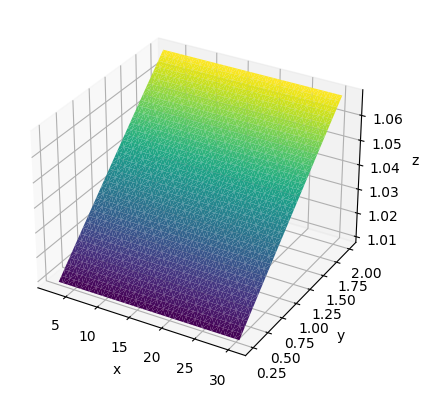

In [276]:
Z = 1
C = 0.06

na = 41  # default 41
D = np.linspace(A, 12 * A, na)
B = 0.25
nb = 41  # default 41
T = np.linspace(B, 8 * B, nb)
Tmax = np.max(T)
lambda_type = 0

N = 1000  # default 1000
r = np.log(1.025)

# Compute bond coupon
d1 = bond_coupon(Z, C, D, T, r, lambda_type, parlambda, distr, params, Tmax, N)
y = d1[:, 0]
x = d1[:, 1] / 1e9
z = d1[:, 2]

# Convert to DataFrame for plotting
data_plot = pd.DataFrame({'x': x, 'y': y, 'z': z})
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(data_plot['x'], data_plot['y'], data_plot['z'], cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [277]:
y

array([0.25, 0.25, 0.25, ..., 2.  , 2.  , 2.  ])